In [1]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.pipelines.pipeline_utils import load_pipeline

torch.set_grad_enabled(False)

In [2]:
from text3d2video.pipelines.texturing_pipeline import TexturingPipeline

pipe = load_pipeline(TexturingPipeline)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim_tag = "catwalk_180_20:latest"
anim_tag = "cat_mv_xatlas:latest"
anim_tag = "mv_penguin:latest"
anim_tag = "mv_backpack:latest"
anim_tag = "mv_cat_statue:latest"
anim_tag = "mv_human_zoom_head:latest"
anim_tag = "human_mv:latest"
anim_tag = "mv_helmet:latest"

texture_anim = AnimationArtifact.from_wandb_artifact_tag(anim_tag)

seq = texture_anim.read_anim_seq()

In [ ]:
texture_art = AnimationArtifact.from_wandb_artifact_tag('catwalk')

In [4]:
from text3d2video.utilities.video_comparison import display_vids
from text3d2video.utilities.video_util import pil_frames_to_clip

prompt = "Jango Fett Helmet"
uvs = seq.render_rgb_uv_maps()
vid = pil_frames_to_clip(uvs, fps=5)
display_vids([vid], title=prompt)

In [32]:
from pathlib import Path
from text3d2video.pipelines.texturing_pipeline import TexturingConfig
from text3d2video.utilities.logging import H5Logger
import torch

texgen_config = TexturingConfig(
    num_inference_steps=10,
    do_text_and_texture_resampling=True,
    use_prev_clean_tex=False,
    use_update_masks=True,
    use_referecnce_kvs=True,
)

generator = torch.Generator(device="cuda")
generator.manual_seed(0)

logger = H5Logger(Path("texgen_data.h5"))
logger.delete_data()
logger.open_write()
logger.enabled = True

images = pipe(
    prompt,
    seq,
    conf=texgen_config,
    generator=generator,
    logger=logger,
)

logger.close()
logger.open_read()

100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


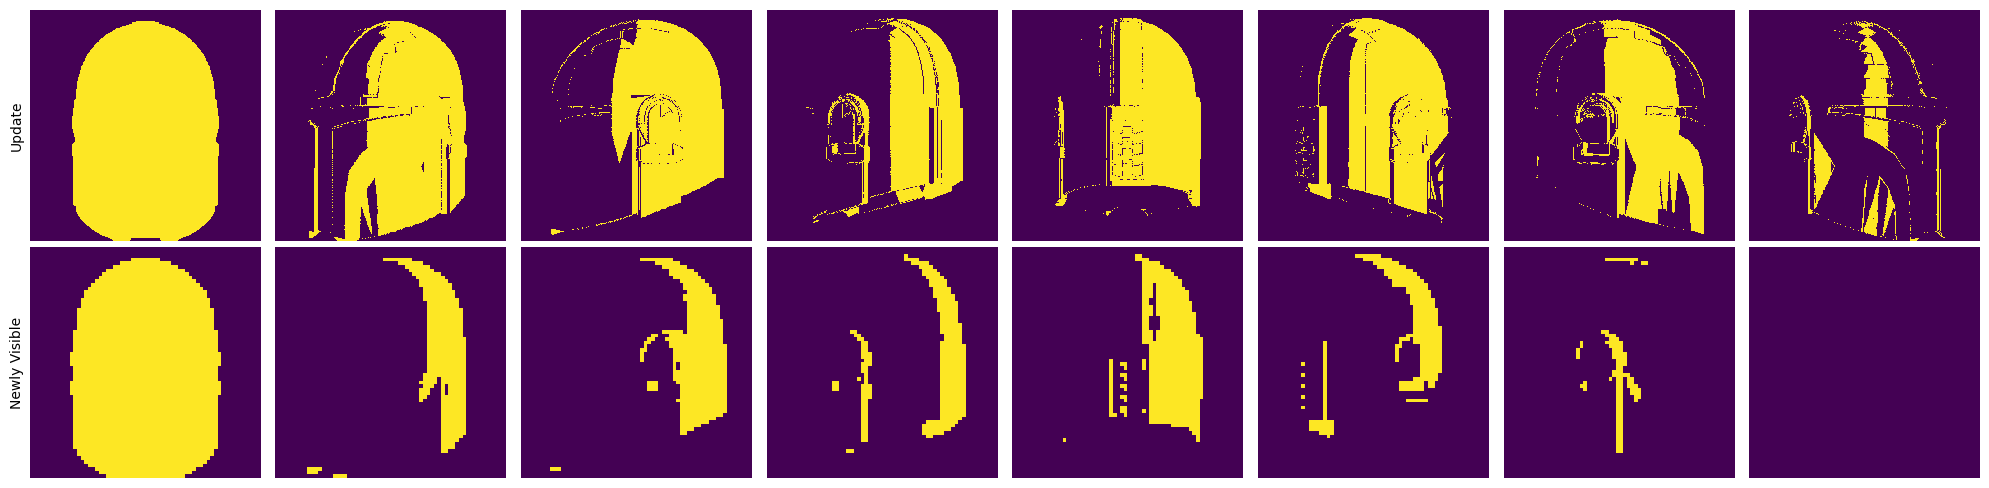

In [33]:
from text3d2video.utilities.ipython_utils import display_ims_grid

update_masks = logger.read("update_masks")
newly_visible = logger.read("newly_visible_masks")

display_ims_grid([update_masks, newly_visible], row_titles=["Update", "Newly Visible"])

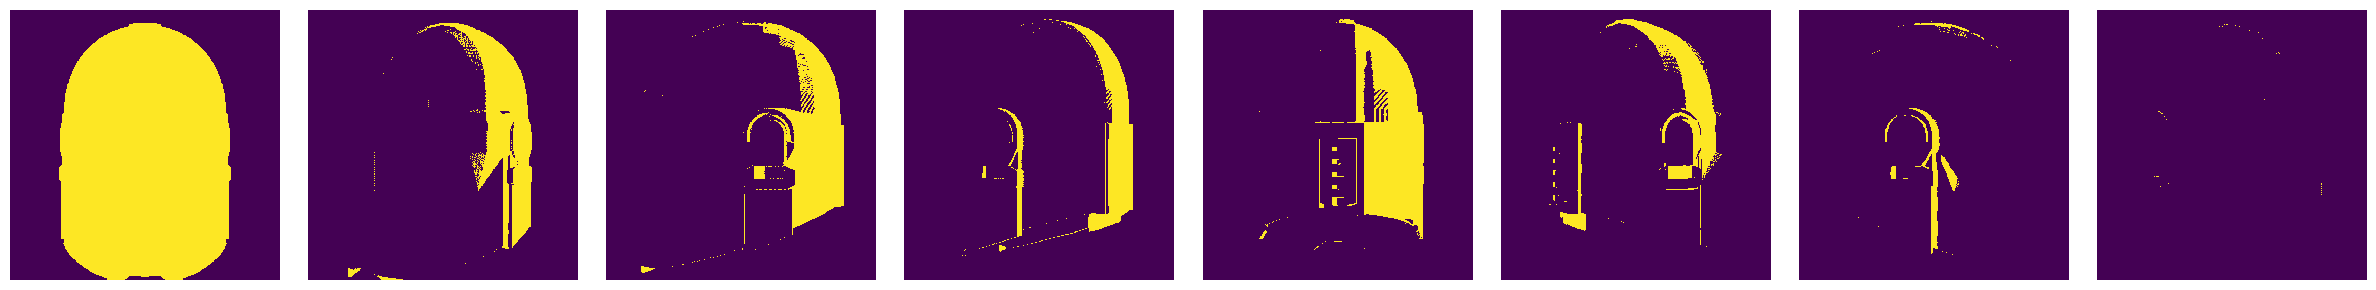

In [34]:
from text3d2video.pipelines.texturing_pipeline import TexturingLogic
from text3d2video.utilities.ipython_utils import display_ims


texgen = TexturingLogic(pipe, use_update_masks=False)

update_masks = texgen.compute_uv_update_masks(seq)

display_ims(update_masks.cpu())

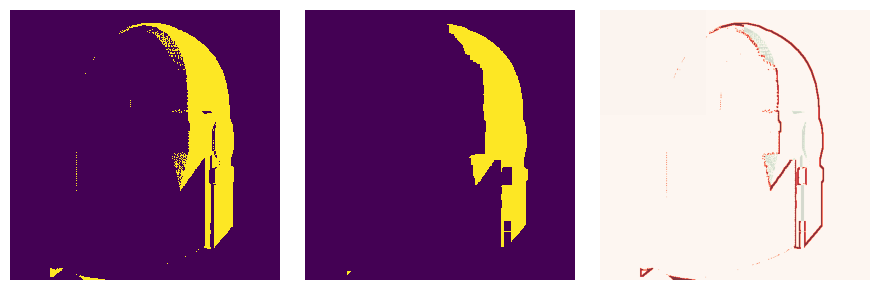

In [35]:
import numpy as np
from torch import Tensor
from scipy.ndimage import binary_erosion, binary_closing

from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.utilities.matplotlib_utils import binary_masks_diff
from text3d2video.utilities.testing_utils import test_img

mask = update_masks[1]

ks1 = 7
ks2 = 7
closed = binary_closing(mask, structure=np.ones((ks1, ks1)))
closed = binary_erosion(closed, structure=np.ones((ks2, ks2)))
closed = Tensor(closed)

# display_ims([mask, closed])
fig, axs = display_ims([mask, closed, test_img()], show=False)
binary_masks_diff(axs[-1], mask, closed)


In [36]:
images_vid = pil_frames_to_clip(images, fps=5)
titles = [prompt]
videos = [images_vid]

display_vids(videos, titles=titles)
# display_ims(images, row_title="ref kvs")

In [37]:
from text3d2video.backprojection import (
    aggregate_views_uv_texture_mean,
    compute_texel_projections,
)
import torchvision.transforms.functional as TF


projections = compute_texel_projections(
    seq.meshes, seq.cams, seq.verts_uvs, seq.faces_uvs, texgen_config.uv_res
)
images_pt = torch.stack([TF.to_tensor(x) for x in images]).cuda()
texture = aggregate_views_uv_texture_mean(images_pt, 600, projections)

(0.0, 1.0, 0.0, 1.0)

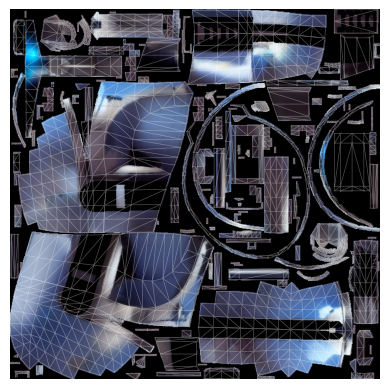

In [38]:
from matplotlib import pyplot as plt

from text3d2video.utilities.matplotlib_utils import mpl_uv_triangulation

tri = mpl_uv_triangulation(seq.verts_uvs, seq.faces_uvs)
plt.triplot(tri, c="white", lw=0.5, alpha=0.3)
plt.imshow(texture.cpu(), extent=[0, 1, 0, 1])
plt.axis("off")

401


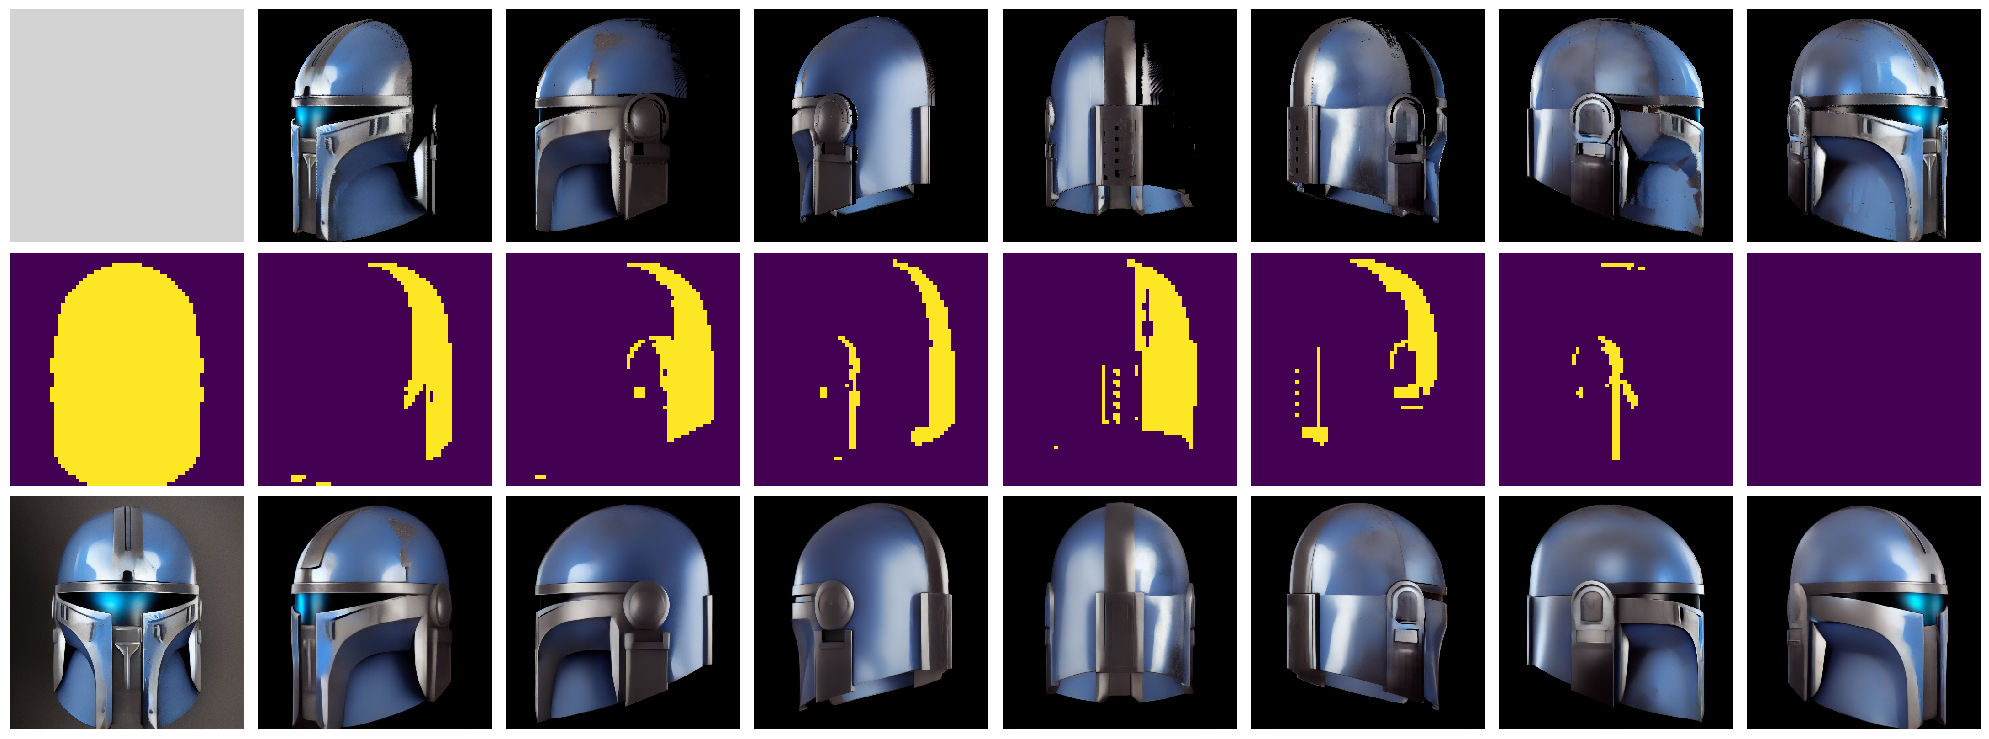

In [39]:
import torchvision.transforms.functional as TF

from text3d2video.util import object_array
from text3d2video.utilities.ipython_utils import display_ims_grid
from text3d2video.utilities.testing_utils import test_img

ts = sorted(logger.key_values("clean_im", "t"), reverse=True)
frame_is = sorted(logger.key_values("clean_im", "frame_i"))

t_vis = ts[5]
print(t_vis)

to_pil = TF.to_pil_image

clean_ims = [
    logger.read("clean_im", t=t_vis, frame_i=f, transform=to_pil) for f in frame_is
]
rendered = [test_img()] + [
    logger.read("rendered", t=t_vis, frame_i=f, transform=to_pil) for f in frame_is[1:]
]

grid = object_array([rendered, newly_visible, clean_ims])
display_ims_grid(grid)

In [ ]:
from text3d2video.rendering import render_texture

vids = []

vid_ts = [ts[-2]]

for texture_t in vid_ts:
    clean_tex = logger.read("clean_tex", t=texture_t).cuda()
    renders = render_texture(
        seq.meshes, seq.cams, clean_tex, seq.verts_uvs, seq.faces_uvs, return_pil=True
    )
    vid = pil_frames_to_clip(renders, fps=5)
    vids.append(vid)

display_vids(vids, titles=[f"t={t}" for t in vid_ts])

: 